In [1]:
#Imports
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("NCAA Champion RawData.csv")
print(list(df.columns))

['Season', '#', 'Team/Season', 'Team', 'Conference', 'Conference/Season', 'Bracket Region', 'Bracket Region/Season', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L2Y cs', 'sum school L4Y cs', 'sum school L6Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps', 'sum school Finals apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'make tournament', 'sum mm tour games', 'sum cf tour games', 'sum cf re

In [3]:
data_columns = ['sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L2Y cs', 'sum school L4Y cs', 'sum school L6Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps', 'sum school Finals apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'make tournament', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum career games', 'sum polls made', 'poll_Pre 1', 'poll_Week 2', 'poll_Week 3', 'poll_Week 4', 'poll_Week 5', 'poll_Week 6', 'poll_Week 7', 'poll_Week 8', 'poll_Week 9', 'poll_Week 10', 'poll_Week 11', 'poll_Week 12', 'poll_Week 13', 'poll_Week 14', 'poll_Week 15', 'poll_Week 16', 'poll_Week 17', 'poll_Week 18', 'poll_avg', 'top_12_Week 12', 'team_rating_avg_custom', 'max_player_rating_custom', 'cf_rating_custom', 'region_rating_custom']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [78]:
correlation_matrix = data.corr()

correlation_threshold = .90

columns_to_remove = set()
print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

Columns to be Removed:
sum conf L5Y cs (correlated with sum conf L3Y cs): 0.94
sum conf L10Y cs (correlated with sum conf L8Y cs): 0.99
sum school L6Y cs (correlated with sum school L4Y cs): 0.93
sum school L10Y cs (correlated with sum school L8Y cs): 0.97
eFG% (correlated with TS%): 0.94
HOB (correlated with AST%): 0.97
TOV (correlated with TOV%): 0.90
SPG (correlated with STL%): 0.93
BPG (correlated with BLK%): 0.93
MOV (correlated with eDiff): 0.99
Win % (correlated with L's): -0.92
FGM (correlated with PPG): 0.91
3PA (correlated with 3PM): 0.92
FTA (correlated with FTM): 0.93
sum career games (correlated with sum cf reg games): 0.99
poll_avg (correlated with sum polls made): 0.91
poll_Week 2 (correlated with poll_Pre 1): 0.99
poll_Week 3 (correlated with poll_Pre 1): 0.94
poll_Week 5 (correlated with poll_Week 4): 0.95
poll_Week 6 (correlated with poll_Week 4): 0.91
poll_Week 8 (correlated with poll_Week 7): 0.98
poll_Week 9 (correlated with poll_Week 7): 0.95
poll_avg (correlated 

In [79]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L8Y cs', 'sum school L1Y cs', 'sum school L2Y cs', 'sum school L4Y cs', 'sum school L8Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps', 'sum school Finals apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'W's', 'L's', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'make tournament', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'region_rating_custom'

Columns that were removed:
'poll_Week 

In [8]:
features = ['sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L8Y cs', 'sum school L1Y cs', 'sum school L2Y cs',
            'sum school L4Y cs', 'sum school L8Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps',
            'sum school Finals apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 
            'FIC40', 'ORtg', 'DRtg', 'MOV', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl',
            '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', 
            '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3',
            'Seed_4', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 
            'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'region_rating_custom']

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 73


In [ ]:
#set features 1:

features = ['sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L8Y cs', 'sum school L1Y cs', 'sum school L2Y cs',
            'sum school L4Y cs', 'sum school L8Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps',
            'sum school Finals apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 
            'FIC40', 'ORtg', 'DRtg', 'MOV', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl',
            '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', 
            '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3',
            'Seed_4', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 
            'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'region_rating_custom']


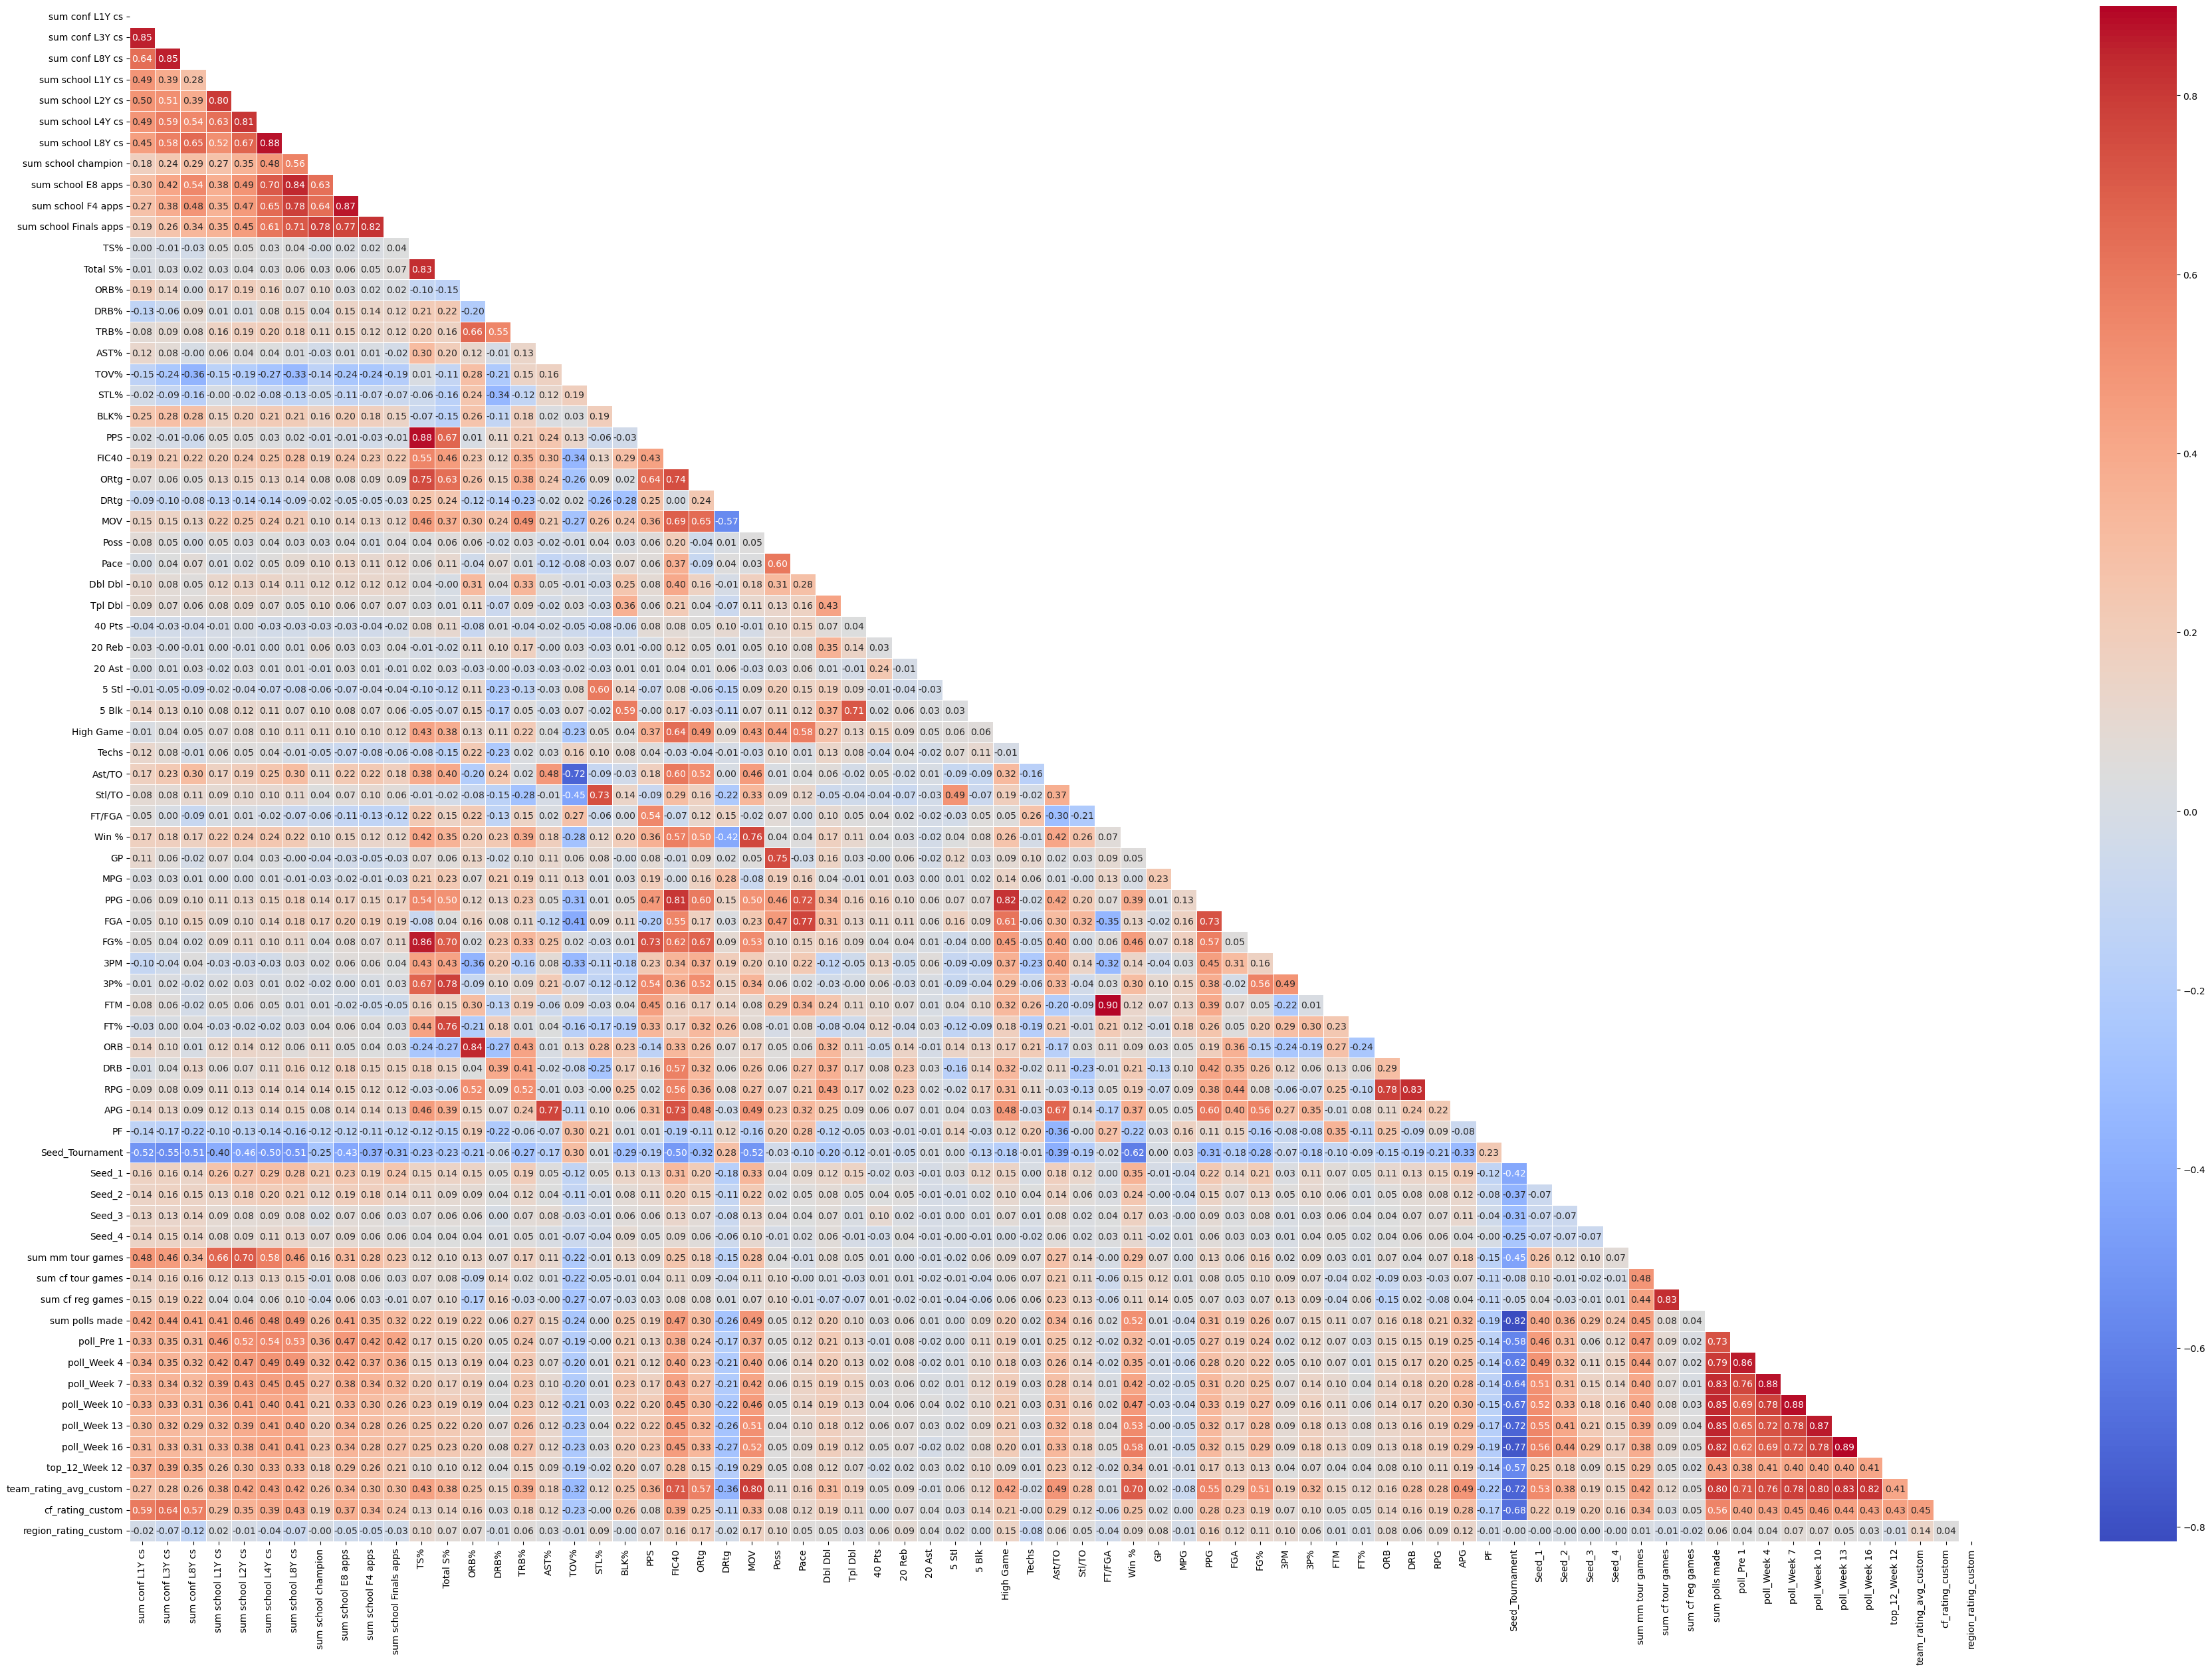

In [9]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(45, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

In [10]:
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#model parameters
rf = RandomForestRegressor(n_estimators=5, random_state=5, min_samples_split=2, max_depth=5)
rf.fit(train[features], train["champion share"])

#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make tournament"] == 1]

predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(5))

Error Metrics: 

PT MAE:  0.13219160174417877
PT MSE:  0.03834972237881456
PT RMSE:  0.19583085144791298
-----------------------------------------------------------------------------

Feature Importance: 

Seed_Tournament           0.462335
sum polls made            0.120528
team_rating_avg_custom    0.086123
poll_Pre 1                0.022852
poll_Week 16              0.020117
sum school champion       0.016171
Dbl Dbl                   0.016016
Poss                      0.015970
sum school L8Y cs         0.015411
3PM                       0.014307
FT/FGA                    0.013208
sum mm tour games         0.012585
STL%                      0.012080
sum school F4 apps        0.010161
3P%                       0.010085
sum cf tour games         0.009268
DRB                       0.008664
region_rating_custom      0.008028
ORtg                      0.007931
Win %                     0.007750
dtype: float64
-----------------------------------------------------------------------------



In [11]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x              Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023       Connecticut          1.000000                    0.400851     1      2023          1.000000                    0.400851               2
1      2023   San Diego State          0.833333                    0.173020     2      2023          0.833333                    0.173020              21
2      2023  Florida Atlantic          0.666667                    0.088124     3      2023          0.666667                    0.088124              42
3      2023        Miami (FL)          0.666667                    0.173020     4      2023          0.666667                    0.173020              22

PT AP Top 4:  0.2067099567099567


In [84]:
all_predictions = []
aps = []

target_seasons = [2021, 2022, 2023]

# Backtesting
for season in target_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)
    print(f"AP for Season {season}: {ap}")

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2021: 0.7732558139534884
AP for Season 2022: 0.35895445134575565
AP for Season 2023: 0.20562770562770563

Average Error Metrics Across All Seasons:
Average MAE: 0.14021612675547687
Average MSE: 0.038060307021128885
Average RMSE: 0.19505626194449033
Average AP: 0.44594599030898324


In [85]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, average_precision_score

target_variable = 'champion share'

train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 25, 100],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'random_state': [1, 5, 10, 15]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 25, 100],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1],
            'random_state': [1, 5, 10, 15]
        }
    }
}

from tqdm import tqdm
results = {}
for model_name, model_info in models.items():
    param_grid = ParameterGrid(model_info['params'])
    best_mae = np.inf
    best_params = None  

    for params in tqdm(param_grid, desc=f"Grid search for {model_name}", position=0, leave=True):
        model = model_info['model'].set_params(**params)
        model.fit(train[features], train[target_variable])
        predictions = model.predict(test[features])

        # Calculate MAE
        mae = mean_absolute_error(test[target_variable], predictions)

        if mae < best_mae:
            best_mae = mae
            best_params = params  # Update best_params when a better model is found

    # Train the model with the best parameters
    final_model = model_info['model'].set_params(**best_params)
    final_model.fit(train[features], train[target_variable])

    # Add the 'predicted champion share' column to the test DataFrame
    test['predicted champion share'] = final_model.predict(test[features])

    # Calculate average precision metric
    ap = find_ap(test)
    
    # Print metrics for each model
    print("=============================================================================\n")
    print(f"Model: {model_name}")
    print(f"PT AP Top 4: {ap}")
    print(f"MAE: {best_mae}")
    print(f"Best Parameters: {best_params}")
    print("-----------------------------------------------------------------------------\n")

    # Store results
    results[model_name] = {
        'MAE': best_mae,
        'Best_Params': best_params,
        'Average_Precision_Top_4': ap
    }

    # Display completion percentage
    completion_percentage = (len(results) / len(models)) * 100
    print(f"Model {model_name} completed. {completion_percentage:.2f}% done.")

print("Grid search and evaluation completed.")

Grid search for RandomForest: 100%|██████████| 240/240 [05:05<00:00,  1.27s/it]



Model: RandomForest
PT AP Top 4: 0.11195804195804197
MAE: 0.1315963268172634
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 5, 'random_state': 10}
-----------------------------------------------------------------------------

Model RandomForest completed. 50.00% done.


Grid search for XGBoost: 100%|██████████| 160/160 [00:08<00:00, 18.95it/s]


Model: XGBoost
PT AP Top 4: 0.09338563800806363
MAE: 0.13765640102901544
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'random_state': 1}
-----------------------------------------------------------------------------

Model XGBoost completed. 100.00% done.
Grid search and evaluation completed.


### Random Forest:

In [15]:
#training/testing
train = df[df["Season"] < 2023].copy()
test = df[df["Season"] == 2023].copy()

#scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])


#rf = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=5, random_state=10) BEST PARAM
#rf = RandomForestRegressor(n_estimators=5, random_state=5, min_samples_split=2, max_depth=5)
####rf = RandomForestRegressor(n_estimators=5, random_state=5, min_samples_split=2, max_depth=5) TRY
#rf = RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=5, random_state=10) bt champion .49
#rf = RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=5, random_state=10) bt champion .48
#rf = RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=5, random_state=10) bt champion .47
#rf = RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=5, random_state=10) bt champion .41
#rf = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=5, random_state=10)
rf = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=5, random_state=10)
rf.fit(train[features], train["champion share"])

#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")

#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")

# Filter to include only playoff teams
frame_playoff = test[test["make tournament"] == 1]

# Predicting
predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(5))

Error Metrics: 

PT MAE:  0.13561311367258727
PT MSE:  0.04164827133142787
PT RMSE:  0.20407908107257802
-----------------------------------------------------------------------------

Feature Importance: 

Seed_Tournament           0.318526
team_rating_avg_custom    0.088883
poll_Week 16              0.060106
sum mm tour games         0.024350
Win %                     0.021211
region_rating_custom      0.020945
DRB                       0.017784
BLK%                      0.017238
poll_Pre 1                0.016968
FT%                       0.016108
Dbl Dbl                   0.014797
sum conf L8Y cs           0.014607
MOV                       0.014554
FTM                       0.014513
TOV%                      0.013948
sum conf L3Y cs           0.013440
FT/FGA                    0.012991
sum polls made            0.012855
RPG                       0.012758
sum cf tour games         0.012499
dtype: float64
-----------------------------------------------------------------------------



### RandomForest Champion Evaluation:

In [21]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

          Team  champion share_x  Season_x  predicted champion share_x     Team/Season_x  Rank  champion share_y  Season_y  predicted champion share_y     Team/Season_y  Predicted Rank
0  Connecticut               1.0      2023                    0.633333  Connecticut 2023     1               1.0      2023                    0.633333  Connecticut 2023               2

PT AP Champion:  0.5


In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming df, features, and rf are defined in your code

all_predictions = []
aps = []

backtest_seasons = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    # Save predictions for the current season to the combined DataFrame
    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

# Print top 5 predicted teams for each season
for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2015: 0.25 | Reciprocal: 4.0
Champion AP for Season 2016: 0.17 | Reciprocal: 6.0
Champion AP for Season 2017: 0.33 | Reciprocal: 3.0
Champion AP for Season 2018: 0.33 | Reciprocal: 3.0
Champion AP for Season 2019: 0.14 | Reciprocal: 7.0
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0
Champion AP for Season 2023: 0.5 | Reciprocal: 2.0

Top 5 Predicted Teams for Season 2015:
           Team  predicted champion share  champion share
438    Kentucky                  0.733333        0.666667
448  Iowa State                  0.571212        0.000000
443     Arizona                  0.533333        0.500000
441        Duke                  0.500000        1.000000
439   Wisconsin                  0.488889        0.833333

Top 5 Predicted Teams for Season 2016:
               Team  predicted champion share  champion share
383  Michigan State                  0.766667        0.000000
377          Kansas                

In [96]:
combined_predictions.to_csv('L3S Preds.csv', index=False)

### Random Forest Top 16 Teams Evaluation:

In [26]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(16) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(16) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                Team  champion share_x  Season_x  predicted champion share_x          Team/Season_x  Rank  champion share_y  Season_y  predicted champion share_y          Team/Season_y  Predicted Rank
0        Connecticut          1.000000      2023                    0.633333       Connecticut 2023     1          1.000000      2023                    0.633333       Connecticut 2023               2
1    San Diego State          0.833333      2023                    0.093635   San Diego State 2023     2          0.833333      2023                    0.093635   San Diego State 2023              37
2   Florida Atlantic          0.666667      2023                    0.092613  Florida Atlantic 2023     3          0.666667      2023                    0.092613  Florida Atlantic 2023              38
3         Miami (FL)          0.666667      2023                    0.147750        Miami (FL) 2023     4          0.666667      2023                    0.147750     

In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming df, features, and rf are defined in your code

all_predictions = []
aps = []

backtest_seasons = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    # Save predictions for the current season to the combined DataFrame
    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Top 16 AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

# Print top 5 predicted teams for each season
for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(16)

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Top 16 AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Top 16 AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Top 16 AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Top 16 AP for Season 2015: 0.59 | Reciprocal: 1.7
Top 16 AP for Season 2016: 0.62 | Reciprocal: 1.62
Top 16 AP for Season 2017: 0.59 | Reciprocal: 1.7
Top 16 AP for Season 2018: 0.52 | Reciprocal: 1.91
Top 16 AP for Season 2019: 0.76 | Reciprocal: 1.31
Top 16 AP for Season 2021: 0.53 | Reciprocal: 1.87
Top 16 AP for Season 2022: 0.6 | Reciprocal: 1.67
Top 16 AP for Season 2023: 0.64 | Reciprocal: 1.56

Average Error Metrics Across All Seasons:
BT Average Top 16 AP: 0.61 | Reciprocal: 1.65
BT Max Top 16 AP: 0.52 | Reciprocal: 1.91
BT Min Top 16 AP: 0.76 | Reciprocal: 1.31


### Feature Evaluation:

Top Features:
['Seed_Tournament', 'team_rating_avg_custom', 'poll_Week 16', 'sum polls made', 'MOV', 'poll_Pre 1', 'sum conf L3Y cs', 'sum school L4Y cs', 'FTM', '5 Blk', 'ORtg', 'RPG', 'sum conf L8Y cs', 'FT%', 'DRB', 'poll_Week 4', 'AST%', 'Stl/TO', 'Dbl Dbl', 'STL%', 'BLK%', 'ORB%', 'TRB%', 'Pace', 'FG%', '3PM', 'sum conf L1Y cs', 'Win %', 'sum mm tour games', 'DRB%', 'PF', 'FT/FGA', '3P%', 'ORB', 'region_rating_custom', 'TOV%', 'poll_Week 10', 'MPG', 'APG', 'Tpl Dbl', 'sum school champion', 'DRtg', '5 Stl', 'sum cf tour games', 'poll_Week 7', 'cf_rating_custom', 'Poss', 'sum school L8Y cs', 'FIC40', 'Ast/TO', 'poll_Week 13', 'sum school E8 apps', 'sum cf reg games', 'High Game', 'sum school L2Y cs', 'PPS', 'TS%', '20 Reb', 'GP', 'Techs', 'Seed_1', 'top_12_Week 12', 'Total S%', 'sum school Finals apps', 'sum school F4 apps', '40 Pts', 'PPG', 'FGA', 'Seed_3', 'Seed_2', 'sum school L1Y cs', 'Seed_4', '20 Ast']


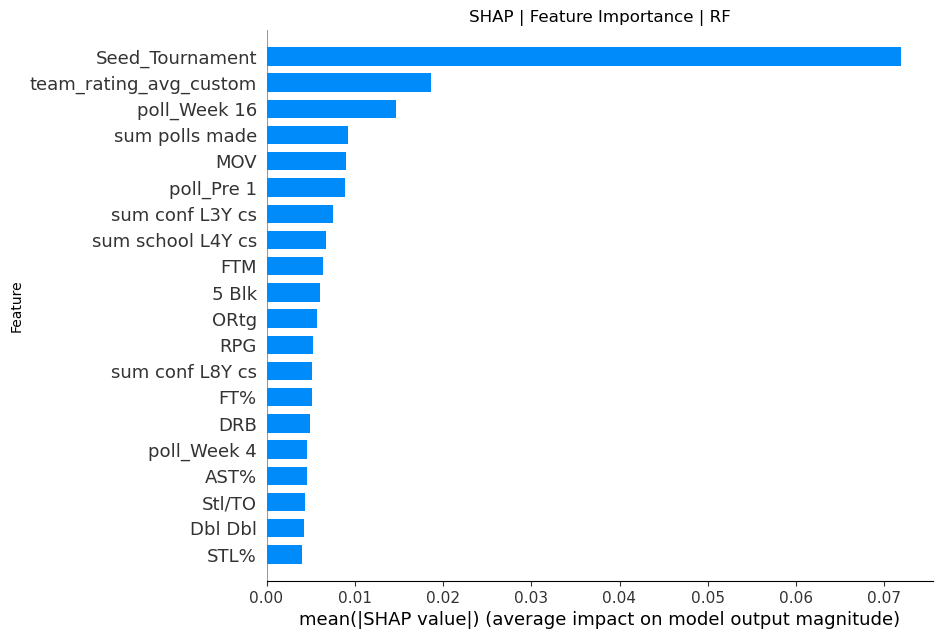

In [18]:
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

shap.summary_plot(shap_values, test[features], feature_names=features, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Feature Importance | RF')
plt.savefig("rf_shap_bar.png", bbox_inches='tight', pad_inches=0.1)

image = Image.open("rf_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_bar.png")

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1]

top_features_list = [features[index] for index in top_features]
print("Top Features:")
print(top_features_list)

plt.ylabel("Feature")
plt.show()

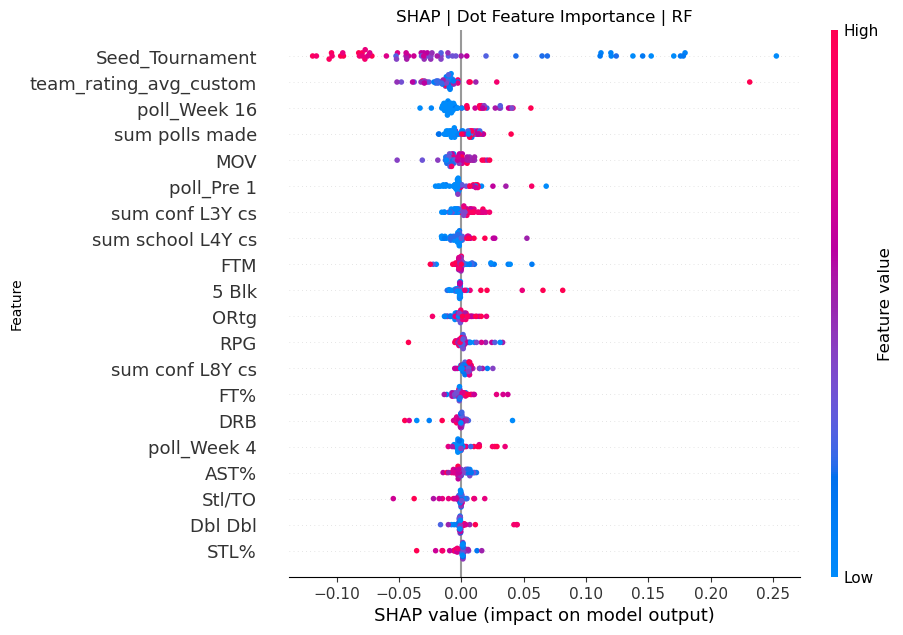

In [11]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | RF')

plt.savefig("rf_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_dot.png")

plt.ylabel("Feature")
plt.show()